In [1]:
# Libs
import pandas as pd
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, silhouette_score, calinski_harabasz_score
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

from transformers import AutoTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, AutoModel
from datasets import Dataset
import torch

from scipy.special import softmax
from statsmodels.stats.proportion import proportion_confint

In [2]:
# General
SEED = 42
TEST_SIZE = 0.4
use_gpu = True
num_classes = 2
random.seed(SEED)

In [3]:
# Check GPU availability
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

True
NVIDIA GeForce RTX 4070 Laptop GPU


# Loading Data

In [4]:
df_kp_labeled = pd.read_feather('../Data/TrainingData/df_kp_labeled.feather')
df_kp_unlabeled = pd.read_feather('../Data/TrainingData/df_kp_unlabeled.feather')

In [5]:
print(df_kp_labeled.head())

   ID_kp  ID_dta                                          KEY_POINT  \
0      6      50  Stress stemmed from the fear of disease progre...   
1      8      50   Not psychologically prepared to manage such s...   
2     16      54  Not psychologically prepared to manage these s...   
3     24      60  Stopping treatment was seen as a sign of recov...   
4     35      68  The expertise of GPs familiar with Crohn's cou...   

                                KEY_POINT_normalized  ID_kp_distinct  label  
0  stress stemmed from the fear of disease progre...               3      1  
1  not psychologically prepared to manage such so...               5      0  
2  not psychologically prepared to manage these s...              11      0  
3  stopping treatment was seen as a sign of recov...              16      1  
4  the expertise of gps familiar with crohn's cou...              26      1  


In [6]:
df_kp_labeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID_kp                 21 non-null     int32 
 1   ID_dta                21 non-null     int32 
 2   KEY_POINT             21 non-null     object
 3   KEY_POINT_normalized  21 non-null     object
 4   ID_kp_distinct        21 non-null     int64 
 5   label                 21 non-null     int64 
dtypes: int32(2), int64(2), object(2)
memory usage: 968.0+ bytes


In [7]:
df_kp_unlabeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID_kp                 107 non-null    int32 
 1   ID_dta                107 non-null    int32 
 2   KEY_POINT             107 non-null    object
 3   KEY_POINT_normalized  107 non-null    object
 4   ID_kp_distinct        107 non-null    int64 
dtypes: int32(2), int64(1), object(2)
memory usage: 3.5+ KB


# Importing Model

In [8]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [9]:
def get_model():
    model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)

    device = "cpu"
    if use_gpu:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    return model

# Data Preprocessing

The data is normalized as follows.

In [10]:
# df_kp['KEY_POINT_normalized'] = df_kp['KEY_POINT'].str.strip().str.replace('\n', ' ').str.replace('\r', ' ').str.lower()

## Tokenizing

In [11]:
all_keypoints = df_kp_labeled['KEY_POINT_normalized'].tolist() + df_kp_unlabeled['KEY_POINT_normalized'].tolist()

tokenized = tokenizer(
    all_keypoints,
    padding=False,
    truncation=False,
    return_tensors=None
)

# Calc max length
lengths = [len(input_ids) for input_ids in tokenized['input_ids']]
max_length = max(lengths)
print(f"Maximum tokenized input length: {max_length}")

Maximum tokenized input length: 119


In [12]:
def tokenize_fn(example):
    return tokenizer(example["KEY_POINT_normalized"], truncation=True, padding="max_length", max_length=max_length)

dataset_labeled = Dataset.from_pandas(df_kp_labeled)
dataset_unlabeled = Dataset.from_pandas(df_kp_unlabeled)

In [13]:
# Labeled
df_tokenized_labeled = dataset_labeled.map(tokenize_fn, batched=True)
df_tokenized_labeled_pd = df_tokenized_labeled.to_pandas()
df_tokenized_labeled_pd['label'] = df_tokenized_labeled_pd['label'].astype(int)

df_tokenized_labeled_pd = df_tokenized_labeled_pd[['input_ids', 'attention_mask', 'label', 'ID_kp_distinct']]
print(df_tokenized_labeled_pd.head())

Map:   0%|          | 0/21 [00:00<?, ? examples/s]

                                           input_ids  \
0  [101, 6911, 27674, 2013, 1996, 3571, 1997, 429...   
1  [101, 2025, 8317, 2135, 4810, 2000, 6133, 2107...   
2  [101, 2025, 8317, 2135, 4810, 2000, 6133, 2122...   
3  [101, 7458, 3949, 2001, 2464, 2004, 1037, 3696...   
4  [101, 1996, 11532, 1997, 14658, 5220, 2007, 13...   

                                      attention_mask  label  ID_kp_distinct  
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...      1               3  
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...      0               5  
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...      0              11  
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...      1              16  
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...      1              26  


In [14]:
# Unlabeled
df_tokenized_unlabeled = dataset_unlabeled.map(tokenize_fn, batched=True)
df_tokenized_unlabeled_pd = df_tokenized_unlabeled.to_pandas()
df_tokenized_unlabeled_pd['label'] = None

df_tokenized_unlabeled_pd = df_tokenized_unlabeled_pd[['input_ids', 'attention_mask', 'label', 'ID_kp_distinct']]
print(df_tokenized_unlabeled_pd.head())

Map:   0%|          | 0/107 [00:00<?, ? examples/s]

                                           input_ids  \
0  [101, 2342, 2000, 5247, 2146, 2847, 1999, 1996...   
1  [101, 5022, 2988, 12503, 2055, 3251, 8030, 202...   
2  [101, 6387, 16342, 1998, 1037, 4568, 2110, 199...   
3  [101, 16436, 8146, 3303, 2011, 13675, 11631, 2...   
4  [101, 1996, 20694, 2791, 1997, 16250, 13441, 3...   

                                      attention_mask label  ID_kp_distinct  
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...  None               0  
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  None               1  
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  None               2  
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  None               4  
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...  None               6  


## Combined Dataset

In [15]:
df_tokenized_combined_pd = pd.concat([df_tokenized_labeled_pd, df_tokenized_unlabeled_pd], ignore_index=True)

In [16]:
df_tokenized_combined_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   input_ids       128 non-null    object
 1   attention_mask  128 non-null    object
 2   label           21 non-null     object
 3   ID_kp_distinct  128 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 4.1+ KB


# Train-Test split

In [17]:
train_df, test_df = train_test_split(
    df_tokenized_labeled_pd,
    test_size=TEST_SIZE,
    stratify=df_tokenized_labeled_pd['label'],
    random_state=SEED
)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [18]:
print(len(train_dataset))
print(len(test_dataset))

12
9


# Unsupervised Learning

## Make embeddings

In [19]:
df_tokenized_combined_pd_train = df_tokenized_combined_pd[
    ~df_tokenized_combined_pd['ID_kp_distinct'].isin(test_df['ID_kp_distinct'])
]

print(len(df_tokenized_combined_pd_train)) # 128 - 9 = 119

119


In [20]:
input_ids = torch.tensor(df_tokenized_combined_pd_train['input_ids'].tolist())
attention_mask = torch.tensor(df_tokenized_combined_pd_train['attention_mask'].tolist())

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_2456\4091883739.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  input_ids = torch.tensor(df_tokenized_combined_pd_train['input_ids'].tolist())


In [21]:
model = AutoModel.from_pretrained("bert-base-uncased")
model.eval()

with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    last_hidden_state = outputs.last_hidden_state
    cls_embeddings = last_hidden_state[:, 0, :]

## PCA

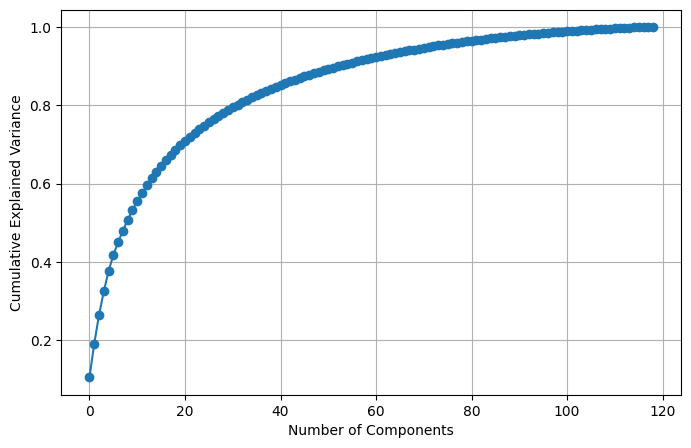

In [22]:
X = cls_embeddings.cpu().numpy()

pca = PCA().fit(X)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.savefig("figs/PCA_ExplainedVariance_kp.png", dpi=300, bbox_inches='tight')
plt.show()

In [23]:
# Scale down with PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=60)
X_pca = pca.fit_transform(X_scaled)

In [24]:
test_input_ids = torch.tensor(test_df['input_ids'].tolist())
test_attention_mask = torch.tensor(test_df['attention_mask'].tolist())

In [25]:
model.eval()
with torch.no_grad():
    outputs_test = model(input_ids=test_input_ids, attention_mask=test_attention_mask)
    last_hidden_state_test = outputs_test.last_hidden_state
    cls_embeddings_test = last_hidden_state_test[:, 0, :]

# Scale down with PCA
X_test = cls_embeddings_test.cpu().numpy()
X_test_scaled = scaler.transform(X_test)        # use same scaler
X_test_pca = pca.transform(X_test_scaled)       # use same PCA

## K-means

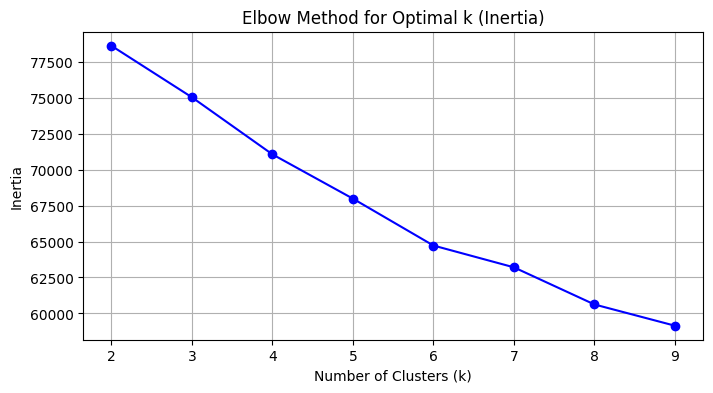

In [26]:
inertia_values = []
k_range = range(2, 10)

# Iterate through the range of k values to compute inertia
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=SEED)
    kmeans.fit(X_pca)
    inertia_values.append(kmeans.inertia_)

# Plot the inertia values vs number of clusters
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia_values, marker='o', color='b')
plt.xticks(k_range)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k (Inertia)")
plt.grid(True)
plt.show()

In [27]:
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=SEED)
cluster_labels = kmeans.fit_predict(X_pca)

df_tokenized_combined_pd_train['cluster'] = cluster_labels

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_2456\1640148921.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tokenized_combined_pd_train['cluster'] = cluster_labels


### Predict scores

In [28]:
df_tokenized_combined_pd_train.head()

,input_ids,attention_mask,label,ID_kp_distinct,cluster
0,"[101, 6911, 27674, 2013, 1996, 3571, 1997, 429...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,3,1
1,"[101, 2025, 8317, 2135, 4810, 2000, 6133, 2107...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...",0,5,0
2,"[101, 2025, 8317, 2135, 4810, 2000, 6133, 2122...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...",0,11,0
3,"[101, 7458, 3949, 2001, 2464, 2004, 1037, 3696...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,16,1
5,"[101, 5197, 1997, 2129, 7435, 10639, 1996, 372...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,36,0


In [29]:
cluster_label_counts = {}

for _, row in df_tokenized_combined_pd_train.iterrows():
    label = row['label']
    cluster = row['cluster']
    
    if label is not None:
        if cluster not in cluster_label_counts:
            cluster_label_counts[cluster] = {0: 0, 1: 0}
        
        cluster_label_counts[cluster][label] += 1

cluster_label_df = pd.DataFrame.from_dict(cluster_label_counts, orient='index')
cluster_label_df = cluster_label_df.fillna(0).astype(int)

# Display the results
print(cluster_label_df)

   0  1
1  3  5
0  3  1


In [30]:
# Predict clusters
test_clusters = kmeans.predict(X_test_pca)

# Assign cluster labels to test_df
test_df = test_df.copy()
test_df['predicted_cluster'] = test_clusters
print(test_df)

                                            input_ids  \
9   [101, 2950, 17402, 1998, 17241, 3141, 2000, 21...   
8   [101, 3768, 1997, 7863, 9181, 2000, 22939, 267...   
7   [101, 3528, 1997, 8030, 1998, 9662, 7368, 2055...   
4   [101, 1996, 11532, 1997, 14658, 5220, 2007, 13...   
19  [101, 10124, 2030, 2053, 9871, 2041, 1011, 199...   
11  [101, 7902, 2001, 2872, 2006, 1996, 2342, 2005...   
12  [101, 2342, 2005, 3154, 1998, 3305, 3085, 2592...   
15  [101, 3768, 1997, 8438, 2013, 9871, 8390, 2001...   
6   [101, 11727, 2036, 2443, 2833, 25654, 2066, 40...   

                                       attention_mask  label  ID_kp_distinct  \
9   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...      0              77   
8   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...      1              73   
7   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...      1              69   
4   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...      1              26   
19  [1, 1, 1, 1, 1, 1, 1, 1, 

In [31]:
sil_score = silhouette_score(X_pca, kmeans.labels_)
ch_score = calinski_harabasz_score(X_pca, kmeans.labels_)

print(sil_score)
print(ch_score)

0.058567274
7.2974067


### Visualization

In [32]:
tsne = TSNE(n_components=2, random_state=SEED, perplexity=15)
embeddings_2d = tsne.fit_transform(cls_embeddings.cpu().numpy())

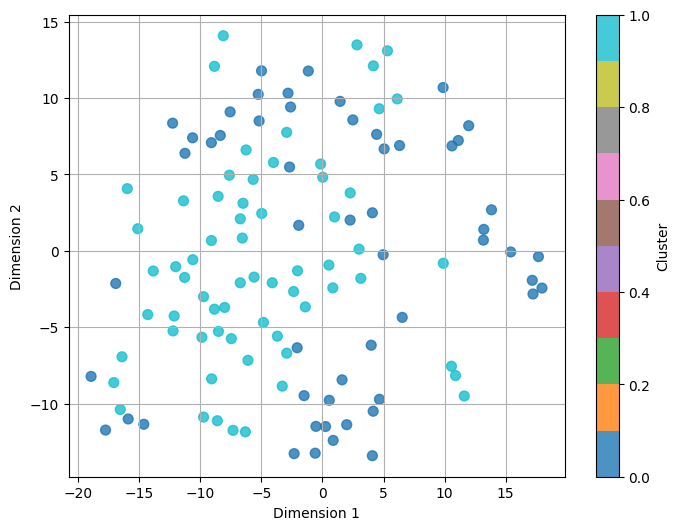

In [33]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1],
    c=df_tokenized_combined_pd_train['cluster'],
    cmap='tab10',
    s=50,
    alpha=0.8
)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

## GMM

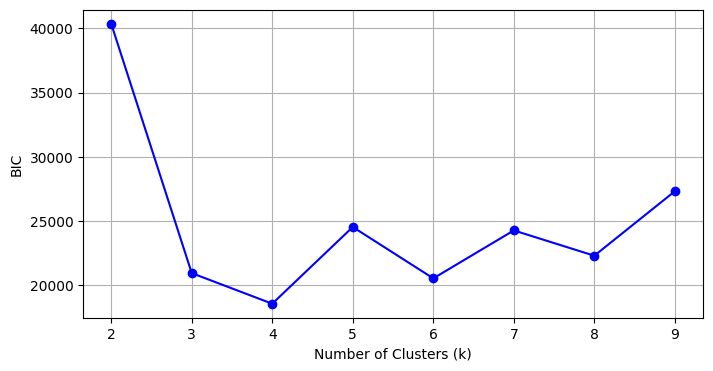

In [34]:
bic_values = []
k_range = range(2, 10)

for k in k_range:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=SEED)
    gmm.fit(X_pca)
    bic_values.append(gmm.bic(X_pca))

plt.figure(figsize=(8, 4))
plt.plot(k_range, bic_values, marker='o', color='b')
plt.xticks(k_range)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("BIC")
plt.grid(True)
plt.show()

In [35]:
n_clusters = 3
gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=SEED)
cluster_labels = gmm.fit_predict(X_pca)

df_tokenized_combined_pd_train['cluster'] = cluster_labels

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_2456\2794324870.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tokenized_combined_pd_train['cluster'] = cluster_labels


### Predict scores

In [36]:
df_tokenized_combined_pd_train.head()

,input_ids,attention_mask,label,ID_kp_distinct,cluster
0,"[101, 6911, 27674, 2013, 1996, 3571, 1997, 429...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,3,0
1,"[101, 2025, 8317, 2135, 4810, 2000, 6133, 2107...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...",0,5,2
2,"[101, 2025, 8317, 2135, 4810, 2000, 6133, 2122...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...",0,11,2
3,"[101, 7458, 3949, 2001, 2464, 2004, 1037, 3696...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,16,2
5,"[101, 5197, 1997, 2129, 7435, 10639, 1996, 372...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,36,2


In [37]:
cluster_label_counts = {}

for _, row in df_tokenized_combined_pd_train.iterrows():
    label = row['label']
    cluster = row['cluster']
    
    if label is not None:
        if cluster not in cluster_label_counts:
            cluster_label_counts[cluster] = {0: 0, 1: 0}
        
        cluster_label_counts[cluster][label] += 1

cluster_label_df = pd.DataFrame.from_dict(cluster_label_counts, orient='index')
cluster_label_df = cluster_label_df.fillna(0).astype(int)

# Display the results
print(cluster_label_df)

   0  1
0  0  3
2  6  1
1  0  2


In [38]:
# Predict clusters for test data using GMM
test_clusters_gmm = gmm.predict(X_test_pca)

# Assign cluster labels to test_df
test_df = test_df.copy()
test_df['predicted_cluster'] = test_clusters_gmm
print(test_df)

                                            input_ids  \
9   [101, 2950, 17402, 1998, 17241, 3141, 2000, 21...   
8   [101, 3768, 1997, 7863, 9181, 2000, 22939, 267...   
7   [101, 3528, 1997, 8030, 1998, 9662, 7368, 2055...   
4   [101, 1996, 11532, 1997, 14658, 5220, 2007, 13...   
19  [101, 10124, 2030, 2053, 9871, 2041, 1011, 199...   
11  [101, 7902, 2001, 2872, 2006, 1996, 2342, 2005...   
12  [101, 2342, 2005, 3154, 1998, 3305, 3085, 2592...   
15  [101, 3768, 1997, 8438, 2013, 9871, 8390, 2001...   
6   [101, 11727, 2036, 2443, 2833, 25654, 2066, 40...   

                                       attention_mask  label  ID_kp_distinct  \
9   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...      0              77   
8   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...      1              73   
7   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...      1              69   
4   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...      1              26   
19  [1, 1, 1, 1, 1, 1, 1, 1, 

In [39]:
sil_score_gmm = silhouette_score(X_pca, gmm.predict(X_pca))
ch_score_gmm = calinski_harabasz_score(X_pca, gmm.predict(X_pca))

print(sil_score_gmm)
print(ch_score_gmm)

0.047053717
6.5602694


### Visualization

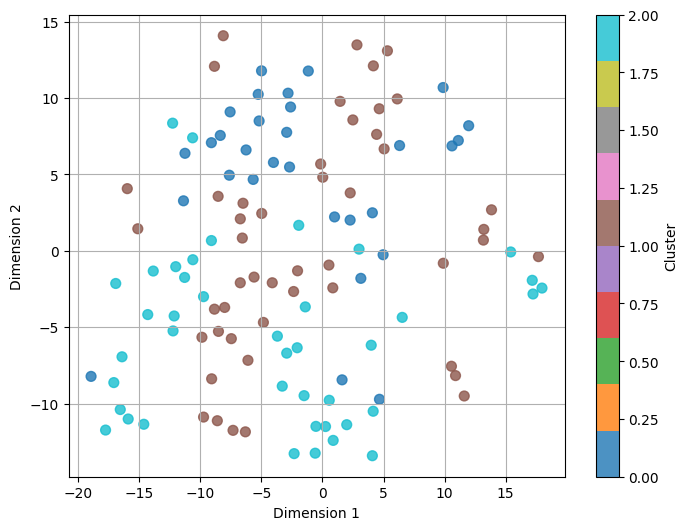

In [40]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1],
    c=df_tokenized_combined_pd_train['cluster'],
    cmap='tab10',
    s=50,
    alpha=0.8
)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.savefig("figs/tsne_gmm_kp.png", dpi=300, bbox_inches='tight')
plt.show()

# Supervised Learning

## Training

In [41]:
training_args = TrainingArguments(
    output_dir="./results/supervised_model",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=1,
    fp16=True,
    dataloader_num_workers=0,
    gradient_accumulation_steps=2
)

In [42]:
trainer = Trainer(
    model=get_model(),
    args=training_args,
    train_dataset=train_dataset
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
trainer.train()

Step,Training Loss
1,0.724100
2,0.676100
3,0.623500
4,0.598300
5,0.601800


TrainOutput(global_step=5, training_loss=0.644757080078125, metrics={'train_runtime': 14.3608, 'train_samples_per_second': 4.178, 'train_steps_per_second': 0.348, 'total_flos': 3669165889200.0, 'train_loss': 0.644757080078125, 'epoch': 5.0})

## Testing

In [44]:
predictions = trainer.predict(test_dataset)

predicted_logits = predictions.predictions
true_labels = predictions.label_ids

predicted_labels = np.argmax(predicted_logits, axis=-1)
print(predicted_labels)
print(true_labels)

[0 1 0 0 1 1 0 1 1]
[0 1 1 1 0 1 1 0 0]


# Semi-Supervised Learning

## Training

In [90]:
training_args = TrainingArguments(
    output_dir="./results/semiSupervised_model",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=1,
    fp16=True,
    dataloader_num_workers=0,
    gradient_accumulation_steps=2
)

In [91]:
model_ss = get_model()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [92]:
def get_trainer(train_dataset, eval_dataset=None):
    trainer = Trainer(
        model=model_ss,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset
    )
    return trainer

In [93]:
k_fold_size = 5  # number of training examples per epoch
val_size = 2     # number of validation examples per fold
early_stopping_patience = 5
num_epochs = 50

best_val_loss = float('inf')
epochs_without_improvement = 0
pseudo_dataset = pd.DataFrame(columns=train_df.columns)

for epoch in range(num_epochs):
    print("\n##################################################")
    print(f"epoch: {epoch+1}")
    print("##################################################")

    if not isinstance(pseudo_dataset, pd.DataFrame):
        pseudo_dataset = pseudo_dataset.to_pandas()

    train_df_shuffled = train_df.sample(frac=1, random_state=SEED+epoch).reset_index(drop=True)
    train_df_subset = train_df_shuffled.iloc[:k_fold_size]
    val_df_subset = train_df_shuffled.iloc[k_fold_size:k_fold_size + val_size]

    train_set_df = pd.concat([train_df_subset, pseudo_dataset], ignore_index=True)
    train_set_df = train_set_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    train_set = Dataset.from_pandas(train_set_df)
    val_set = Dataset.from_pandas(val_df_subset)

    trainer = get_trainer(train_dataset=train_set, eval_dataset=val_set)
    trainer.train()

    eval_results = trainer.evaluate()
    val_loss = eval_results["eval_loss"]
    print(f"Validation Loss: {val_loss:.4f}")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        print(f"No improvement for {epochs_without_improvement} epoch(s).")

    if epochs_without_improvement >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

    # Predict on new batch
    batch = Dataset.from_pandas(df_tokenized_unlabeled_pd)
    sampled_batch = batch.shuffle(seed=SEED+epoch).select(range(3))
    logits = trainer.predict(sampled_batch).predictions
    preds = np.argmax(logits, axis=1)

    pseudo_dataset = sampled_batch.remove_columns('label')
    pseudo_dataset = pseudo_dataset.add_column('label', preds)


##################################################
epoch: 1
##################################################


Step,Training Loss
1,0.371400


Validation Loss: 1.0481


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 2
##################################################


Step,Training Loss
1,0.270900


Validation Loss: 0.3778


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 3
##################################################


Step,Training Loss
1,0.282800


Validation Loss: 0.3523


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 4
##################################################


Step,Training Loss
1,0.232500


Validation Loss: 1.1729
No improvement for 1 epoch(s).


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 5
##################################################


Step,Training Loss
1,0.302300


Validation Loss: 0.3503


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 6
##################################################


Step,Training Loss
1,0.285500


Validation Loss: 0.5125
No improvement for 1 epoch(s).


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 7
##################################################


Step,Training Loss
1,0.183400


Validation Loss: 0.2728


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 8
##################################################


Step,Training Loss
1,0.193200


Validation Loss: 0.1822


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 9
##################################################


Step,Training Loss
1,0.152400


Validation Loss: 0.1764


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 10
##################################################


Step,Training Loss
1,0.112100


Validation Loss: 0.2206
No improvement for 1 epoch(s).


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 11
##################################################


Step,Training Loss
1,0.173100


Validation Loss: 0.1749


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 12
##################################################


Step,Training Loss
1,0.144300


Validation Loss: 0.3691
No improvement for 1 epoch(s).


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 13
##################################################


Step,Training Loss
1,0.099400


Validation Loss: 0.1802
No improvement for 2 epoch(s).


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 14
##################################################


Step,Training Loss
1,0.152500


Validation Loss: 0.1745


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 15
##################################################


Step,Training Loss
1,0.077400


Validation Loss: 0.1577


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 16
##################################################


Step,Training Loss
1,0.073000


Validation Loss: 0.7567
No improvement for 1 epoch(s).


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 17
##################################################


Step,Training Loss
1,0.065000


Validation Loss: 0.3414
No improvement for 2 epoch(s).


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 18
##################################################


Step,Training Loss
1,0.144700


Validation Loss: 0.1179


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 19
##################################################


Step,Training Loss
1,0.064600


Validation Loss: 0.1318
No improvement for 1 epoch(s).


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 20
##################################################


Step,Training Loss
1,0.196700


Validation Loss: 0.1110


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 21
##################################################


Step,Training Loss
1,0.065000


Validation Loss: 0.1057


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 22
##################################################


Step,Training Loss
1,0.089200


Validation Loss: 0.1101
No improvement for 1 epoch(s).


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 23
##################################################


Step,Training Loss
1,0.186800


Validation Loss: 0.1191
No improvement for 2 epoch(s).


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 24
##################################################


Step,Training Loss
1,0.237000


Validation Loss: 0.1216
No improvement for 3 epoch(s).


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 25
##################################################


Step,Training Loss
1,0.172000


Validation Loss: 0.1302
No improvement for 4 epoch(s).


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 26
##################################################


Step,Training Loss
1,0.077300


Validation Loss: 0.1123
No improvement for 5 epoch(s).
Early stopping triggered after 26 epochs.


## Testing

In [95]:
predictions = trainer.predict(test_dataset)

predicted_logits = predictions.predictions
true_labels = predictions.label_ids

predicted_labels = np.argmax(predicted_logits, axis=-1)
print(predicted_labels)
print(true_labels)

[0 0 1 1 0 1 0 1 0]
[0 1 1 1 0 1 1 0 0]


# Simulating CI (Clopper-Pearson)

In [57]:
k = 6     # correct predictions
n = 9     # total predictions

ci_low, ci_high = proportion_confint(k, n, alpha=0.1, method="beta")
print(f"95% CI: [{ci_low:.2%}, {ci_high:.2%}]")

95% CI: [34.49%, 90.23%]


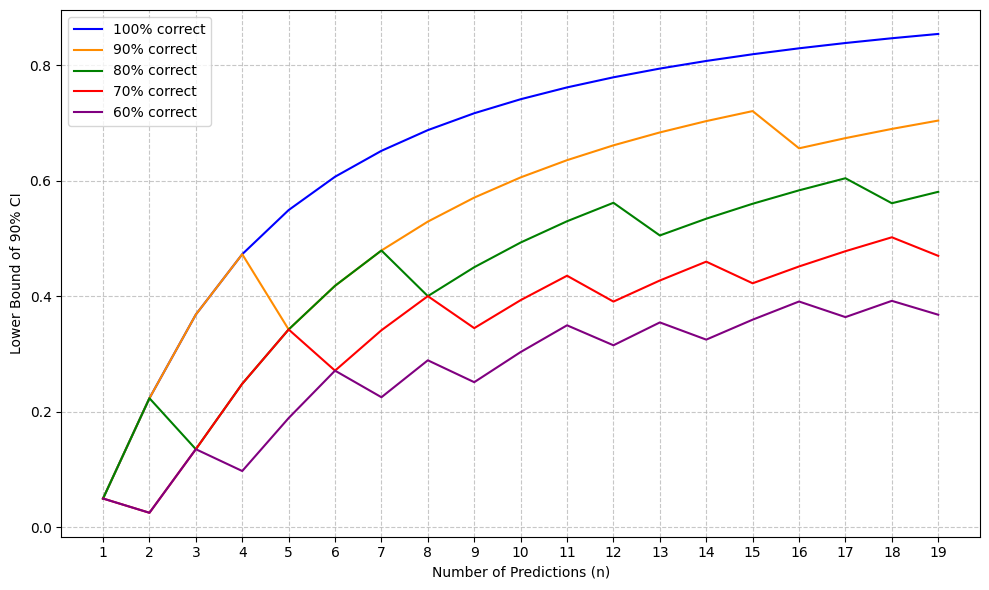

In [53]:
n_values = np.arange(1, 20)
accuracy_levels = [1.0, 0.9, 0.8, 0.7, 0.6]
ci_lows_dict = {f"{int(acc*100)}%": [] for acc in accuracy_levels}

for n in n_values:
    for acc in accuracy_levels:
        k = int(round(acc * n))
        ci_low, _ = proportion_confint(k, n, alpha=0.1, method='beta')
        ci_lows_dict[f"{int(acc*100)}%"].append(ci_low)

# Plotting
plt.figure(figsize=(10, 6))

colors = ['blue', 'darkorange', 'green', 'red', 'purple']

for (label, ci_lows), color, marker in zip(ci_lows_dict.items(), colors, markers):
    plt.plot(n_values, ci_lows, label=f'{label} correct', color=color)

plt.xlabel("Number of Predictions (n)")
plt.ylabel("Lower Bound of 90% CI")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.xticks(n_values)
plt.savefig("figs/CP_lowerBounds.png", dpi=300, bbox_inches='tight')
plt.show()